In [20]:
# tools
import pandas as pd
import matplotlib.pyplot as plt
from utilsforecast.plotting import plot_series

# forecast
from mlforecast import MLForecast

# model
import lightgbm as lgb
from mlforecast.target_transforms import Differences

# evaluate
from utilsforecast.evaluation import evaluate
from utilsforecast.losses import rmse

# data

In [4]:
Y_df = pd.read_csv('https://datasets-nixtla.s3.amazonaws.com/m4-hourly.csv')
print(Y_df.head())
print()
print(Y_df.shape)
print()
print(Y_df["unique_id"].value_counts())

  unique_id  ds      y
0        H1   1  605.0
1        H1   2  586.0
2        H1   3  586.0
3        H1   4  559.0
4        H1   5  511.0

(373372, 3)

unique_id
H286    1008
H283    1008
H290    1008
H289    1008
H288    1008
        ... 
H163     748
H164     748
H165     748
H166     748
H99      748
Name: count, Length: 414, dtype: int64


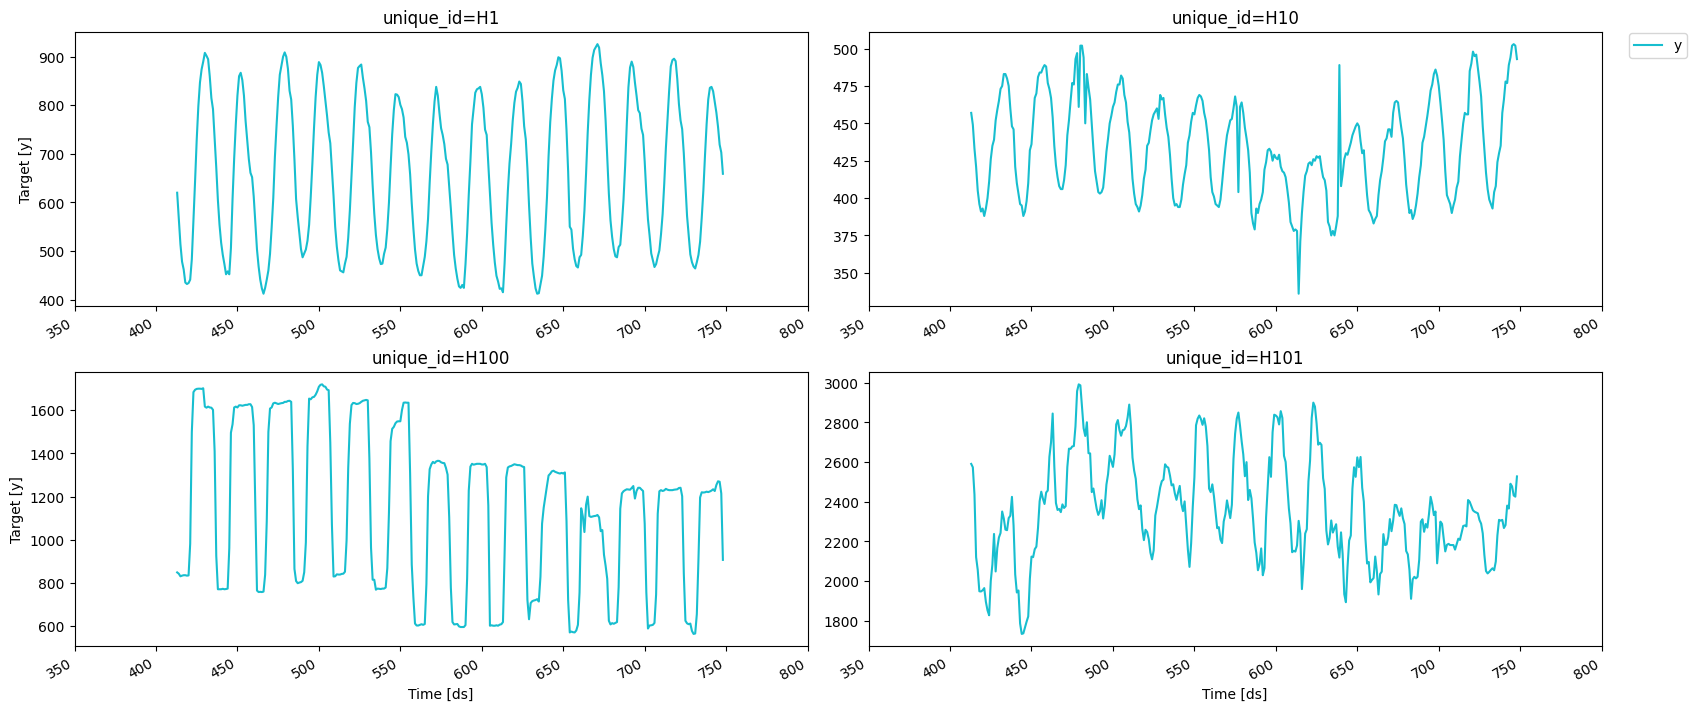

In [3]:
fig = plot_series(Y_df, max_ids = 4, plot_random = False, max_insample_length = 24 * 14)
fig

# model

In [6]:
mlf = MLForecast(
    models = [lgb.LGBMRegressor(verbosity = -1)],
    freq = 1,
    target_transforms = [Differences([24])],
    lags = range(1, 25),
)

# cross validation

In [7]:
cv_df = mlf.cross_validation(
    df = Y_df,
    h = 24,
    n_windows = 3,
)

In [10]:
print(cv_df)
print()
print(cv_df.shape)
print()
print(cv_df["unique_id"].value_counts())

      unique_id   ds  cutoff        y  LGBMRegressor
0            H1  677     676    691.0     673.703191
1            H1  678     676    618.0     552.306270
2            H1  679     676    563.0     541.778027
3            H1  680     676    529.0     502.778027
4            H1  681     676    504.0     480.778027
...         ...  ...     ...      ...            ...
29803       H99  744     724  24039.0   25007.861346
29804       H99  745     724  22946.0   23918.861346
29805       H99  746     724  22217.0   23657.861346
29806       H99  747     724  21416.0   22808.861346
29807       H99  748     724  19531.0   20557.861346

[29808 rows x 5 columns]

(29808, 5)

unique_id
H1      72
H344    72
H353    72
H352    72
H351    72
        ..
H220    72
H22     72
H219    72
H218    72
H99     72
Name: count, Length: 414, dtype: int64


In [17]:
def plot_cv(df, df_cv, uid, fname, last_n=24 * 14):
    cutoffs = df_cv.query('unique_id == @uid')['cutoff'].unique()
    fig, ax = plt.subplots(nrows=len(cutoffs), ncols=1, figsize=(14, 6), gridspec_kw=dict(hspace=0.8))
    for cutoff, axi in zip(cutoffs, ax.flat):
        df.query('unique_id == @uid').tail(last_n).set_index('ds').plot(ax=axi, title=uid, y='y')
        df_cv.query('unique_id == @uid & cutoff == @cutoff').set_index('ds').plot(ax=axi, title=uid, y='LGBMRegressor')
    fig.savefig(fname, bbox_inches='tight')
    plt.show()
    plt.close()

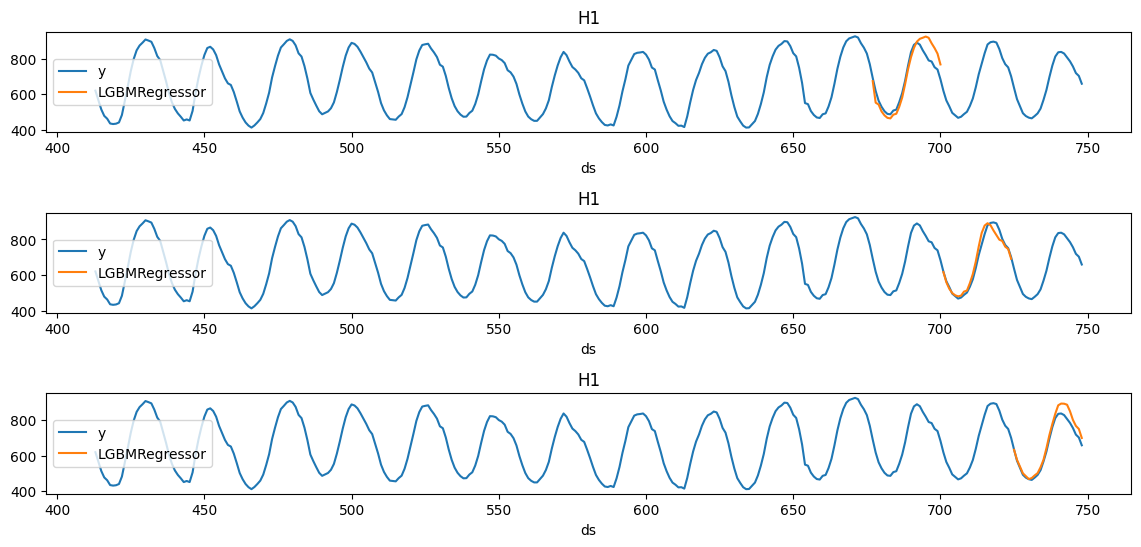

In [19]:
plot_cv(Y_df, cv_df, 'H1', 'E:/projects/timeseries_forecasting/tsproj/models_ml/ml_forecast/utils/figs/cross_validation__predictions.png')

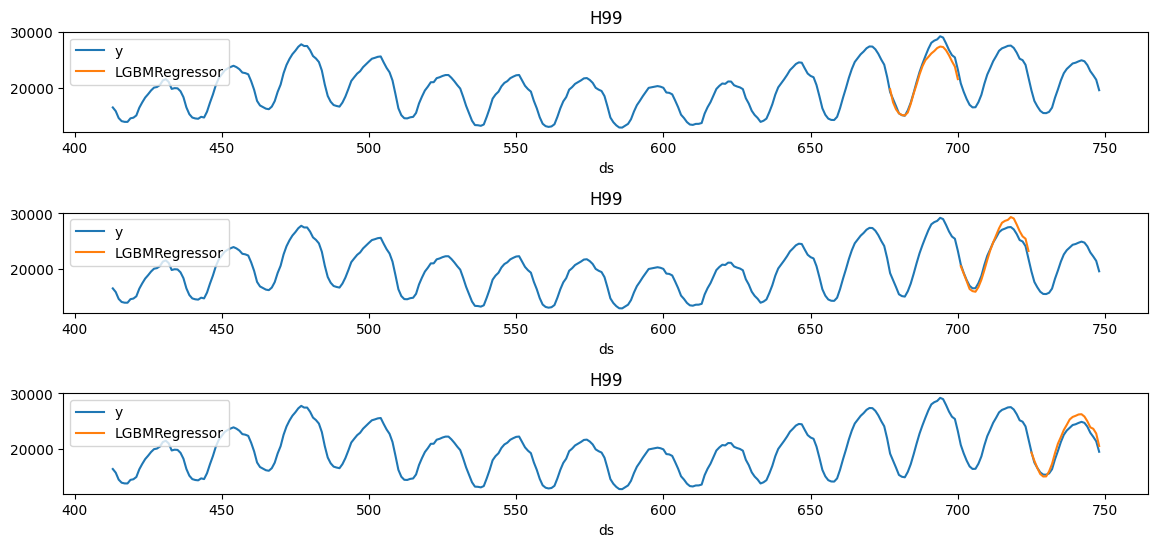

In [18]:
plot_cv(Y_df, cv_df, 'H99', 'E:/projects/timeseries_forecasting/tsproj/models_ml/ml_forecast/utils/figs/cross_validation__predictions.png')

# evaluate

In [21]:
cv_df.head()

,unique_id,ds,cutoff,y,LGBMRegressor
0,H1,677,676,691.0,673.703191
1,H1,678,676,618.0,552.306270
2,H1,679,676,563.0,541.778027
3,H1,680,676,529.0,502.778027
4,H1,681,676,504.0,480.778027


In [22]:
cv_rmse = evaluate(
    cv_df.drop(columns = "cutoff"),
    metrics = [rmse],
    agg_fn = "mean",
)
print(f"RMSE using cross-validation: {cv_rmse['LGBMRegressor'].item():.1f}")

RMSE using cross-validation: 269.0
